# Imports

In [ ]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import torchvision
import torch
import lightning.pytorch as pl

from sklearn.decomposition import PCA
from src.model.full_model import SubCellProtModel,SubCellProtModel_bce
from src.utils.data_handling_utils import initialize_datasets, Retrieval_Data
from src.utils.batch_run_utils import batch_call, get_cell_lines_of_interest, get_isoforms_of_interest, construct_embedding_df
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import os
import time
from enum import Enum
import pdb
import pickle
import math
from src.dataset.dataset import SubCellDatset, DatasetType, CLASSES
from PIL import Image

import sklearn
import sklearn.ensemble
import sklearn.neighbors
import seaborn as sns

fig = plt.figure()

from skimage.transform import resize
from skimage.filters import threshold_otsu
from skimage.filters import gaussian
from skimage.measure import label
from skimage.segmentation import clear_border
from skimage.morphology import remove_small_objects, remove_small_holes
from skimage.exposure import rescale_intensity
from scipy.ndimage import center_of_mass
from pymongo import MongoClient

## File locations / hyperparameters

In [2]:

proteinnames=['EIF4G1-218','DDIT3-202','N4BP2-201','CHID1-201','COPA-208','ATP13A5-201','MESD-201','RBM23-203','PSME3IP1-217']

In [5]:
proteinInput={}

with MongoClient(maxPoolSize=500) as client:
    for p in proteinnames:
        splice_isoforms_collection = client.hpa.splice_isoforms
        isoform_data = list(
            splice_isoforms_collection.find(
                {"_id": p}
            )
        )[0]

        proteinInput[p.split('-')[0]]=(pickle.loads(isoform_data["esm2_representation"]["binary"]),isoform_data["length"]) 


In [7]:
COLLECTION_NAME = "splice_isoform_no_split_2"
MODEL_CHECKPOINT='checkpoints/splice_isoform_dataset_cell_line_and_gene_split_full-epoch=01-val_combined_loss=0.18.ckpt'
loaded_model = SubCellProtModel().load_from_checkpoint(
    MODEL_CHECKPOINT,
    collection_name=COLLECTION_NAME,
    batch_size=32,
)
loaded_model=loaded_model.double()

In [8]:
targetSize=128
targetPixelSize=0.08*4

expPixelSize=0.1
expSize=targetPixelSize*targetSize/expPixelSize
scaleFactor=expPixelSize/targetPixelSize

In [9]:
expDataDir='2024-03-06_HPA_proLoc/'
savedir=os.path.join(expDataDir,'result_imgNorm')
if not os.path.exists(savedir):
    os.mkdir(savedir)
from imaris_ims_file_reader.ims import ims

In [10]:
def process_patch(stain, c1, c2, c3, c4,filter_low_values,percentileNorm):
    if not percentileNorm:
        stain=rescale_intensity(stain[c1:c2, c3:c4].astype(np.float32), out_range=(0, 1))
    else:
        thresh=np.percentile(stain[c1:c2, c3:c4],99.5)
        stain=np.copy(stain[c1:c2, c3:c4])
        stain[stain>thresh]=thresh
        stain=rescale_intensity(stain, out_range=(0, 1))
    stain[stain < filter_low_values] = 0
    return stain

In [11]:
def getXstack_imgNorm(imgPath,scaleFactor,filter_low_values=0.19,percentileNorm=False,imgThresh=99.97,ifLogScale=False):
    testImg=ims(imgPath)
    testImg_dapi=np.max(testImg[0,2],axis=0)+0.1
    testImg_target=np.max(testImg[0,3],axis=0)+0.1
    testImg_tub=np.max(testImg[0,0],axis=0)+0.1
    testImg_er=np.max(testImg[0,1],axis=0)+0.1
    #log
    if ifLogScale:
        testImg_dapi=np.log(testImg_dapi)
        testImg_target=np.log(testImg_target)
        testImg_tub=np.log(testImg_tub)
        testImg_er=np.log(testImg_er)
    
    #norm entire image
    testImg_dapi_thresh=np.percentile(testImg_dapi,imgThresh)
    testImg_dapi[testImg_dapi>testImg_dapi_thresh]=testImg_dapi_thresh
    testImg_er_thresh=np.percentile(testImg_er,imgThresh)
    testImg_er[testImg_er>testImg_er_thresh]=testImg_er_thresh
    testImg_tub_thresh=np.percentile(testImg_tub,imgThresh)
    testImg_tub[testImg_tub>testImg_tub_thresh]=testImg_tub_thresh
    testImg_target_thresh=np.percentile(testImg_target,imgThresh)
    testImg_target[testImg_target>testImg_target_thresh]=testImg_target_thresh
    
    testImg_dapi=rescale_intensity(testImg_dapi,out_range=(0,1))
    testImg_outSize=int(scaleFactor*testImg_dapi.shape[0])
    testImg_dapi=resize(testImg_dapi,(testImg_outSize,testImg_outSize))
    testImg_target=resize(testImg_target,(testImg_outSize,testImg_outSize))
    testImg_tub=resize(testImg_tub,(testImg_outSize,testImg_outSize))
    testImg_er=resize(testImg_er,(testImg_outSize,testImg_outSize))
    
    min_nuc_size = 100
    val = threshold_otsu(testImg_dapi)
    smoothed_nuclei = gaussian(testImg_dapi, sigma=5.0)
    binary_nuclei = smoothed_nuclei > val
    binary_nuclei = remove_small_holes(binary_nuclei, area_threshold=300)
    labeled_nuclei = label(binary_nuclei)
    labeled_nuclei = clear_border(labeled_nuclei)
    labeled_nuclei = remove_small_objects(labeled_nuclei, min_size=min_nuc_size)

    validCount=0
    X_landmarks=np.zeros((np.max(labeled_nuclei),3,targetSize,targetSize))
    y_true=np.zeros((np.max(labeled_nuclei),targetSize,targetSize))
    # Iterate through each nuclei and get their centers (if the object is valid)
    for i in range(1, np.max(labeled_nuclei)):
        current_nuc = labeled_nuclei == i
        if np.sum(current_nuc) > min_nuc_size:
            y, x = center_of_mass(current_nuc)
            x = int(x)
            y = int(y)

            c1 = y - targetSize // 2  # cropsize
            c2 = y + targetSize // 2
            c3 = x - targetSize // 2
            c4 = x + targetSize // 2

            if (
                c1 < 0
                or c3 < 0
                or c2 > testImg_dapi.shape[0]
                or c4 > testImg_dapi.shape[1]
            ):
                pass
            else:

                X_landmarks[validCount,0] = process_patch(testImg_dapi, c1, c2, c3, c4,filter_low_values,percentileNorm)
                X_landmarks[validCount,1] = process_patch(testImg_tub, c1, c2, c3, c4,filter_low_values,percentileNorm)
                X_landmarks[validCount,2] = process_patch(testImg_er, c1, c2, c3, c4,filter_low_values,percentileNorm)
                y_true[validCount]=process_patch(testImg_target, c1, c2, c3, c4,0,percentileNorm)
                validCount+=1
    X_landmarks=X_landmarks[:validCount]
    y_true=y_true[:validCount]           
    return X_landmarks,y_true

In [151]:
lossMSE=torch.nn.MSELoss()

savedir=os.path.join(expDataDir,'result_imgNorm_lower')
imgThresh=99.92
if not os.path.exists(savedir):
    os.mkdir(savedir)
    
# lossPred_all={}
for imgName in os.listdir(expDataDir):
    
    if not imgName[-3:]=='ims':
        continue
    print(imgName[:-4])
    cellline=imgName.split('_')[0]
    p=imgName.split('_')[2]
    print(cellline)
    print(p)
    if p not in proteinInput:
        p=imgName.split('_')[1]
        if p not in proteinInput:
            continue
        
    if p not in lossPred_all.keys():
        lossPred_all[p]={}
    if cellline not in lossPred_all[p].keys():
        lossPred_all[p][cellline]={}
    
    savedir_p=os.path.join(savedir,p)
    if not os.path.exists(savedir_p):
        os.mkdir(savedir_p)
    savedir_p=os.path.join(savedir_p,cellline)
    if not os.path.exists(savedir_p):
        os.mkdir(savedir_p)
#     if os.path.exists(os.path.join(savedir_p,imgName[:-4]+'_pred.jpg')):
#         continue
        
    X_esm2_encoding,X_protein_len=proteinInput[p]
    X_landmarks_orig,_=getXstack_imgNorm(os.path.join(expDataDir,imgName),scaleFactor,0,imgThresh=imgThresh)
    X_landmarks,y_true=getXstack_imgNorm(os.path.join(expDataDir,imgName),scaleFactor,0.19,imgThresh=imgThresh)
    lossPred=np.zeros(X_landmarks.shape[0])
    
    
    plotExample=np.zeros((8*(targetSize+2),X_landmarks.shape[0]*(targetSize+2)))
    
    if X_landmarks.shape[0]==0:
        continue
    for celli in range(X_landmarks.shape[0]):
#         print(celli)
        imgSize=X_landmarks.shape[-1]
        plotExample[0*(imgSize+2):0*(imgSize+2)+imgSize,celli*(imgSize+2):celli*(imgSize+2)+imgSize]=X_landmarks_orig[celli,0]
        plotExample[1*(imgSize+2):1*(imgSize+2)+imgSize,celli*(imgSize+2):celli*(imgSize+2)+imgSize]=X_landmarks_orig[celli,1]
        plotExample[2*(imgSize+2):2*(imgSize+2)+imgSize,celli*(imgSize+2):celli*(imgSize+2)+imgSize]=X_landmarks_orig[celli,2]
        plotExample[3*(imgSize+2):3*(imgSize+2)+imgSize,celli*(imgSize+2):celli*(imgSize+2)+imgSize]=X_landmarks[celli,0]
        plotExample[4*(imgSize+2):4*(imgSize+2)+imgSize,celli*(imgSize+2):celli*(imgSize+2)+imgSize]=X_landmarks[celli,1]
        plotExample[5*(imgSize+2):5*(imgSize+2)+imgSize,celli*(imgSize+2):celli*(imgSize+2)+imgSize]=X_landmarks[celli,2]
        plotExample[6*(imgSize+2):6*(imgSize+2)+imgSize,celli*(imgSize+2):celli*(imgSize+2)+imgSize]=y_true[celli]

        y_pred_antibody_stain, _y_pred_multilabel, _y_pred_ranked = loaded_model.predict_step(
            (
                X_esm2_encoding.unsqueeze(0).double(),
                torch.Tensor([X_protein_len]),
                torch.Tensor(X_landmarks[celli]).unsqueeze(0).double(),
                None,
                None,
            ),
            batch_idx=0,
        )
        plotExample[7*(imgSize+2):7*(imgSize+2)+imgSize,celli*(imgSize+2):celli*(imgSize+2)+imgSize]=y_pred_antibody_stain.detach().numpy()[0][0]
        
        currloss=lossMSE(y_pred_antibody_stain,torch.tensor(y_true[celli].reshape(1,1,128,128))).detach().numpy()
        lossPred[celli]=currloss
#         print(currloss)
    plt.imsave(os.path.join(savedir_p,imgName[:-4]+'_pred.jpg'),plotExample)
    print(np.sum(lossPred)/lossPred.size)
    lossPred_all[p][cellline][imgName]=lossPred
    
savedir=os.path.join(expDataDir,'result_imgNorm')

GAMG_6_ATP13A5_Z-stack_HF_01_2024-03-06_YunHao_23.07.10
GAMG
ATP13A5
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_6_ATP13A5_Z-stack_HF_01_2024-03-06_YunHao_23.07.10.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_6_ATP13A5_Z-stack_HF_01_2024-03-06_YunHao_23.07.10.ims 

Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_6_ATP13A5_Z-stack_HF_01_2024-03-06_YunHao_23.07.10.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_6_ATP13A5_Z-stack_HF_01_2024-03-06_YunHao_23.07.10.ims 

0.02878582059852476
GAMG_5_COPA_Z-stack_HF_06_2024-03-06_YunHao_22.57.14
GAMG
COPA
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_5_COPA_Z-stack_HF_06_2024-03-06_YunHao_22.57.14.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_5_COPA_Z-stack_HF_06_2024-03-06_YunHao_22.57.14

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/Hela_6_ATP13A5_Z-stack_HF_02_2024-03-06_YunHao_23.42.58.ims 

0.03721924018342546
A375_8_RBM23_Z-stack_HF_02_2024-03-07_YunHao_01.32.31
A375
RBM23
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/A375_8_RBM23_Z-stack_HF_02_2024-03-07_YunHao_01.32.31.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/A375_8_RBM23_Z-stack_HF_02_2024-03-07_YunHao_01.32.31.ims 

Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/A375_8_RBM23_Z-stack_HF_02_2024-03-07_YunHao_01.32.31.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/A375_8_RBM23_Z-stack_HF_02_2024-03-07_YunHao_01.32.31.ims 

0.024924732209856488
A375_1_EIF4G1_Z-stack_HF_05_2024-03-06_YunHao_18.10.48
A375
EIF4G1
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/A375_1_EIF4G1_Z-stack_HF_05_2024-03-

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_7_MESD_Z-stack_HF_03_2024-03-07_YunHao_01.02.01.ims 

Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_7_MESD_Z-stack_HF_03_2024-03-07_YunHao_01.02.01.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_7_MESD_Z-stack_HF_03_2024-03-07_YunHao_01.02.01.ims 

0.04149936038388578
Hela_4_CHID1_Z-stack_HF_03_2024-03-06_YunHao_21.38.34
Hela
CHID1
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/Hela_4_CHID1_Z-stack_HF_03_2024-03-06_YunHao_21.38.34.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/Hela_4_CHID1_Z-stack_HF_03_2024-03-06_YunHao_21.38.34.ims 

Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/Hela_4_CHID1_Z-stack_HF_03_2024-03-06_YunHao_21.38.34.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA

0.04558040269511809
MCF7_9_PSME3IP1_Z-stack_HF_04_2024-03-07_YunHao_02.43.09
MCF7
PSME3IP1
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_9_PSME3IP1_Z-stack_HF_04_2024-03-07_YunHao_02.43.09.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_9_PSME3IP1_Z-stack_HF_04_2024-03-07_YunHao_02.43.09.ims 

Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_9_PSME3IP1_Z-stack_HF_04_2024-03-07_YunHao_02.43.09.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_9_PSME3IP1_Z-stack_HF_04_2024-03-07_YunHao_02.43.09.ims 

0.018807271743119507
MCF7_1_EIF4G1_Z-stack_HF_04_2024-03-06_YunHao_18.37.05
MCF7
EIF4G1
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_1_EIF4G1_Z-stack_HF_04_2024-03-06_YunHao_18.37.05.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_1_EIF4G1_Z-sta

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/HEK_1_EIF4G1_Z-stack_HF_04_2024-03-06_YunHao_18.01.40.ims 

0.01626996025044606
A375_2_DDIT3_Z-stack_HF_02_2024-03-06_YunHao_19.26.02
A375
DDIT3
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/A375_2_DDIT3_Z-stack_HF_02_2024-03-06_YunHao_19.26.02.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/A375_2_DDIT3_Z-stack_HF_02_2024-03-06_YunHao_19.26.02.ims 

Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/A375_2_DDIT3_Z-stack_HF_02_2024-03-06_YunHao_19.26.02.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/A375_2_DDIT3_Z-stack_HF_02_2024-03-06_YunHao_19.26.02.ims 

0.013643098443096706
A375_6_ATP13A5_Z-stack_HF_01_2024-03-06_YunHao_23.31.23
A375
ATP13A5
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/A375_6_ATP13A5_Z-stack_HF_01_2024-03

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_5_COPA_Z-stack_HF_06_2024-03-06_YunHao_22.52.40.ims 

0.039146149632340956
A375_4_CHID1_Z-stack_HF_03_2024-03-06_YunHao_21.27.25
A375
CHID1
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/A375_4_CHID1_Z-stack_HF_03_2024-03-06_YunHao_21.27.25.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/A375_4_CHID1_Z-stack_HF_03_2024-03-06_YunHao_21.27.25.ims 

Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/A375_4_CHID1_Z-stack_HF_03_2024-03-06_YunHao_21.27.25.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/A375_4_CHID1_Z-stack_HF_03_2024-03-06_YunHao_21.27.25.ims 

0.018842636552318052
Hela_3_N4BP2_Z-stack_HF_06_2024-03-06_YunHao_20.14.32
Hela
N4BP2
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/Hela_3_N4BP2_Z-stack_HF_06_2024-03-06_Yu

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/HEK_COPA_Z-stack_HF_04_2024-03-06_YunHao_22.05.34.ims 

0.027954619807146353
HEK_9_PSME3IP1_Z-stack_HF_05_2024-03-07_YunHao_02.06.32
HEK
PSME3IP1
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/HEK_9_PSME3IP1_Z-stack_HF_05_2024-03-07_YunHao_02.06.32.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/HEK_9_PSME3IP1_Z-stack_HF_05_2024-03-07_YunHao_02.06.32.ims 

Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/HEK_9_PSME3IP1_Z-stack_HF_05_2024-03-07_YunHao_02.06.32.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/HEK_9_PSME3IP1_Z-stack_HF_05_2024-03-07_YunHao_02.06.32.ims 

0.02255297733929026
MCF7_5_COPA_Z-stack_HF_01_2024-03-06_YunHao_22.40.03
MCF7
COPA
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_5_COPA_Z-stack_HF_01_2024-03-

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/Hela_8_RBM23_Z-stack_HF_01_2024-03-07_YunHao_01.40.39.ims 

0.021721369474923157
MCF7_9_PSME3IP1_Z-stack_HF_06_2024-03-07_YunHao_02.46.19
MCF7
PSME3IP1
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_9_PSME3IP1_Z-stack_HF_06_2024-03-07_YunHao_02.46.19.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_9_PSME3IP1_Z-stack_HF_06_2024-03-07_YunHao_02.46.19.ims 

Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_9_PSME3IP1_Z-stack_HF_06_2024-03-07_YunHao_02.46.19.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_9_PSME3IP1_Z-stack_HF_06_2024-03-07_YunHao_02.46.19.ims 

0.018066581278476997
MCF7_5_COPA_Z-stack_HF_02_2024-03-06_YunHao_22.41.38
MCF7
COPA
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_5_COPA_Z-stack_HF_

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/HEK_8_RBM23_Z-stack_HF_02_2024-03-07_YunHao_01.50.18.ims 

0.039797072418308384
HEK_1_EIF4G1_Z-stack_HF_06_2024-03-06_YunHao_18.04.56
HEK
EIF4G1
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/HEK_1_EIF4G1_Z-stack_HF_06_2024-03-06_YunHao_18.04.56.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/HEK_1_EIF4G1_Z-stack_HF_06_2024-03-06_YunHao_18.04.56.ims 

Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/HEK_1_EIF4G1_Z-stack_HF_06_2024-03-06_YunHao_18.04.56.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/HEK_1_EIF4G1_Z-stack_HF_06_2024-03-06_YunHao_18.04.56.ims 

0.0198922477221988
GAMG_1_EIF4G1_Z-stack_HF_04_2024-03-06_YunHao_18.50.36
GAMG
EIF4G1
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_1_EIF4G1_Z-stack_HF_04_2024-03-06_Y

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_2_DDIT3_Z-stack_HF_05_2024-03-06_YunHao_19.12.17.ims 

Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_2_DDIT3_Z-stack_HF_05_2024-03-06_YunHao_19.12.17.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_2_DDIT3_Z-stack_HF_05_2024-03-06_YunHao_19.12.17.ims 

0.01631156875782583
HEK_7_MESD_Z-stack_HF_02_2024-03-07_YunHao_00.04.50
HEK
MESD
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/HEK_7_MESD_Z-stack_HF_02_2024-03-07_YunHao_00.04.50.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/HEK_7_MESD_Z-stack_HF_02_2024-03-07_YunHao_00.04.50.ims 

Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/HEK_7_MESD_Z-stack_HF_02_2024-03-07_YunHao_00.04.50.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc

0.01643131811884828
Hela_8_RBM23_Z-stack_HF_05_2024-03-07_YunHao_01.45.49
Hela
RBM23
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/Hela_8_RBM23_Z-stack_HF_05_2024-03-07_YunHao_01.45.49.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/Hela_8_RBM23_Z-stack_HF_05_2024-03-07_YunHao_01.45.49.ims 

Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/Hela_8_RBM23_Z-stack_HF_05_2024-03-07_YunHao_01.45.49.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/Hela_8_RBM23_Z-stack_HF_05_2024-03-07_YunHao_01.45.49.ims 

0.025638452569485798
A375_5_COPA_Z-stack_HF_06_2024-03-06_YunHao_22.25.32
A375
COPA
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/A375_5_COPA_Z-stack_HF_06_2024-03-06_YunHao_22.25.32.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/A375_5_COPA_Z-stack_HF_06_2024-03-06_YunHao

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_9_PSME3IP1_Z-stack_HF_06_2024-03-07_YunHao_02.55.13.ims 

0.016822861464024536
HEK_7_MESD_Z-stack_HF_03_2024-03-07_YunHao_00.06.20
HEK
MESD
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/HEK_7_MESD_Z-stack_HF_03_2024-03-07_YunHao_00.06.20.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/HEK_7_MESD_Z-stack_HF_03_2024-03-07_YunHao_00.06.20.ims 

Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/HEK_7_MESD_Z-stack_HF_03_2024-03-07_YunHao_00.06.20.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/HEK_7_MESD_Z-stack_HF_03_2024-03-07_YunHao_00.06.20.ims 

0.045189857233011166
HEK_2_DDIT3_Z-stack_HF_01_2024-03-06_YunHao_19.44.15
HEK
DDIT3
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/HEK_2_DDIT3_Z-stack_HF_01_2024-03-06_YunHao_19.44.

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/Hela_4_CHID1_Z-stack_HF_06_2024-03-06_YunHao_21.34.33.ims 

Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/Hela_4_CHID1_Z-stack_HF_06_2024-03-06_YunHao_21.34.33.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/Hela_4_CHID1_Z-stack_HF_06_2024-03-06_YunHao_21.34.33.ims 

0.01572815862218732
A375_7_MESD_Z-stack_HF_01_2024-03-07_YunHao_00.25.05
A375
MESD
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/A375_7_MESD_Z-stack_HF_01_2024-03-07_YunHao_00.25.05.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/A375_7_MESD_Z-stack_HF_01_2024-03-07_YunHao_00.25.05.ims 

Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/A375_7_MESD_Z-stack_HF_01_2024-03-07_YunHao_00.25.05.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_p

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/Hela_5_COPA_Z-stack_HF_04_2024-03-06_YunHao_22.18.06.ims 

0.045335691028771316
MCF7_3_N4BP2_Z-stack_HF_02_2024-03-06_YunHao_20.32.51
MCF7
N4BP2
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_3_N4BP2_Z-stack_HF_02_2024-03-06_YunHao_20.32.51.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_3_N4BP2_Z-stack_HF_02_2024-03-06_YunHao_20.32.51.ims 

Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_3_N4BP2_Z-stack_HF_02_2024-03-06_YunHao_20.32.51.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_3_N4BP2_Z-stack_HF_02_2024-03-06_YunHao_20.32.51.ims 

0.02231072537020367
Hela_5_COPA_Z-stack_HF_01_2024-03-06_YunHao_22.12.56
Hela
COPA
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/Hela_5_COPA_Z-stack_HF_01_2024-03-06_YunHao

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_1_EIF4G1_Z-stack_HF_05_2024-03-06_YunHao_18.40.07.ims 

Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_1_EIF4G1_Z-stack_HF_05_2024-03-06_YunHao_18.40.07.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_1_EIF4G1_Z-stack_HF_05_2024-03-06_YunHao_18.40.07.ims 

0.02283715963851391
GAMG_1_EIF4G1_Z-stack_HF_02_2024-03-06_YunHao_18.48.41
GAMG
EIF4G1
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_1_EIF4G1_Z-stack_HF_02_2024-03-06_YunHao_18.48.41.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_1_EIF4G1_Z-stack_HF_02_2024-03-06_YunHao_18.48.41.ims 

Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_1_EIF4G1_Z-stack_HF_02_2024-03-06_YunHao_18.48.41.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/202

0.04047410376528445
A375_1_EIF4G1_Z-stack_HF_01_2024-03-06_YunHao_18.24.46
A375
EIF4G1
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/A375_1_EIF4G1_Z-stack_HF_01_2024-03-06_YunHao_18.24.46.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/A375_1_EIF4G1_Z-stack_HF_01_2024-03-06_YunHao_18.24.46.ims 

Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/A375_1_EIF4G1_Z-stack_HF_01_2024-03-06_YunHao_18.24.46.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/A375_1_EIF4G1_Z-stack_HF_01_2024-03-06_YunHao_18.24.46.ims 

0.023294832459865848
MCF7_6_ATP13A5_Z-stack_HF_04_2024-03-06_YunHao_23.23.12
MCF7
ATP13A5
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_6_ATP13A5_Z-stack_HF_04_2024-03-06_YunHao_23.23.12.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_6_ATP13A5_Z-stack_HF_04

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/A375_7_MESD_Z-stack_HF_03_2024-03-07_YunHao_00.27.49.ims 

0.04821473194442381
Hela_8_RBM23_Z-stack_HF_06_2024-03-07_YunHao_01.47.11
Hela
RBM23
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/Hela_8_RBM23_Z-stack_HF_06_2024-03-07_YunHao_01.47.11.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/Hela_8_RBM23_Z-stack_HF_06_2024-03-07_YunHao_01.47.11.ims 

Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/Hela_8_RBM23_Z-stack_HF_06_2024-03-07_YunHao_01.47.11.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/Hela_8_RBM23_Z-stack_HF_06_2024-03-07_YunHao_01.47.11.ims 

0.02465115843277943
HEK_2_DDIT3_Z-stack_HF_05_2024-03-06_YunHao_19.50.37
HEK
DDIT3
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/HEK_2_DDIT3_Z-stack_HF_05_2024-03-06_YunHao_

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_3_N4BP2_Z-stack_HF_04_2024-03-06_YunHao_20.45.38.ims 

Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_3_N4BP2_Z-stack_HF_04_2024-03-06_YunHao_20.45.38.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_3_N4BP2_Z-stack_HF_04_2024-03-06_YunHao_20.45.38.ims 

0.017035704805601036
HEK_CHID1_Z-stack_HF_05_2024-03-06_YunHao_21.53.50
HEK
Z-stack
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/HEK_CHID1_Z-stack_HF_05_2024-03-06_YunHao_21.53.50.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/HEK_CHID1_Z-stack_HF_05_2024-03-06_YunHao_21.53.50.ims 

Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/HEK_CHID1_Z-stack_HF_05_2024-03-06_YunHao_21.53.50.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_3_N4BP2_Z-stack_HF_03_2024-03-06_YunHao_20.35.18.ims 

Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_3_N4BP2_Z-stack_HF_03_2024-03-06_YunHao_20.35.18.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_3_N4BP2_Z-stack_HF_03_2024-03-06_YunHao_20.35.18.ims 

0.02402297624920586
MCF7_6_ATP13A5_Z-stack_HF_01_2024-03-06_YunHao_23.19.12
MCF7
ATP13A5
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_6_ATP13A5_Z-stack_HF_01_2024-03-06_YunHao_23.19.12.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_6_ATP13A5_Z-stack_HF_01_2024-03-06_YunHao_23.19.12.ims 

Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_6_ATP13A5_Z-stack_HF_01_2024-03-06_YunHao_23.19.12.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2

0.012493574917853802
Hela_0_bg_Z-stack_HF_07_2024-03-06_YunHao_17.48.47
Hela
bg
MCF7_5_COPA_Z-stack_HF_04_2024-03-06_YunHao_22.44.53
MCF7
COPA
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_5_COPA_Z-stack_HF_04_2024-03-06_YunHao_22.44.53.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_5_COPA_Z-stack_HF_04_2024-03-06_YunHao_22.44.53.ims 

Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_5_COPA_Z-stack_HF_04_2024-03-06_YunHao_22.44.53.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_5_COPA_Z-stack_HF_04_2024-03-06_YunHao_22.44.53.ims 

0.03799219430033512
MCF7_6_ATP13A5_Z-stack_HF_02_2024-03-06_YunHao_23.20.41
MCF7
ATP13A5
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_6_ATP13A5_Z-stack_HF_02_2024-03-06_YunHao_23.20.41.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/202

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_1_EIF4G1_Z-stack_HF_02_2024-03-06_YunHao_18.32.46.ims 

0.03814431735984502
MCF7_6_ATP13A5_Z-stack_HF_03_2024-03-06_YunHao_23.21.52
MCF7
ATP13A5
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_6_ATP13A5_Z-stack_HF_03_2024-03-06_YunHao_23.21.52.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_6_ATP13A5_Z-stack_HF_03_2024-03-06_YunHao_23.21.52.ims 

Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_6_ATP13A5_Z-stack_HF_03_2024-03-06_YunHao_23.21.52.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_6_ATP13A5_Z-stack_HF_03_2024-03-06_YunHao_23.21.52.ims 

0.041636648659084535
GAMG_2_DDIT3_Z-stack_HF_06_2024-03-06_YunHao_19.08.53
GAMG
DDIT3
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_2_DDIT3_Z-stack_HF_06_

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/Hela_6_ATP13A5_Z-stack_HF_05_2024-03-06_YunHao_23.47.10.ims 

0.02655847269050105


In [21]:
with open(os.path.join(savedir,'mseloss'), 'wb') as output:
    pickle.dump(lossPred_all, output, pickle.HIGHEST_PROTOCOL)

## plot nuclear localization

In [17]:
from stardist.models import StarDist2D
from csbdeep.utils import normalize
from skimage.filters import gaussian
from skimage.measure import label
from skimage.segmentation import clear_border
from skimage.morphology import remove_small_objects, remove_small_holes
from scipy.ndimage.measurements import center_of_mass

2508730219.py (7): Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.


In [18]:
model_stardist = StarDist2D.from_pretrained('2D_versatile_fluo')

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


2024-03-13 18:39:52.526120: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-13 18:39:52.533412: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [53]:
#save landmarks,true, pred
imgsAll={}
imgsAll_currentCount={}
for p in lossPred_all.keys():
    imgsAll[p]={}
    imgsAll_currentCount[p]={}
    for cellline in lossPred_all[p].keys():
        nimgs=0
        for imgName in lossPred_all[p][cellline].keys():
            nimgs+=lossPred_all[p][cellline][imgName].size
        imgsAll[p][cellline]=np.zeros((nimgs,5,imgSize,imgSize))
        imgsAll_currentCount[p][cellline]=0

In [54]:
nucProp_all_pred={}
nucProp_all_true={}
for imgName in os.listdir(expDataDir):
    
    if not imgName[-3:]=='ims':
        continue
    print(imgName[:-4])
    cellline=imgName.split('_')[0]
    p=imgName.split('_')[2]
    print(cellline)
    print(p)
    if p not in proteinInput:
        p=imgName.split('_')[1]
        if p not in proteinInput:
            continue
        
    if p not in nucProp_all_pred.keys():
        nucProp_all_pred[p]={}
    if cellline not in nucProp_all_pred[p].keys():
        nucProp_all_pred[p][cellline]={}
    if p not in nucProp_all_true.keys():
        nucProp_all_true[p]={}
    if cellline not in nucProp_all_true[p].keys():
        nucProp_all_true[p][cellline]={}
    
#     if os.path.exists(os.path.join(savedir_p,imgName[:-4]+'_pred.jpg')):
#         continue
        
    X_esm2_encoding,X_protein_len=proteinInput[p]
    X_landmarks,y_true=getXstack_imgNorm(os.path.join(expDataDir,imgName),scaleFactor,0.19)
    nucProp_pred=np.zeros(X_landmarks.shape[0])
    nucProp_true=np.zeros(X_landmarks.shape[0])
    
    if X_landmarks.shape[0]==0:
        continue
    prev_nimgs=imgsAll_currentCount[p][cellline]
    curr_nimags=X_landmarks.shape[0]
    imgsAll[p][cellline][prev_nimgs:prev_nimgs+curr_nimags,:3]=X_landmarks
    imgsAll[p][cellline][prev_nimgs:prev_nimgs+curr_nimags,3]=y_true
    
    
    for celli in range(X_landmarks.shape[0]):
        y_pred_antibody_stain, _y_pred_multilabel, _y_pred_ranked = loaded_model.predict_step(
            (
                X_esm2_encoding.unsqueeze(0).double(),
                torch.Tensor([X_protein_len]),
                torch.Tensor(X_landmarks[celli]).unsqueeze(0).double(),
                None,
                None,
            ),
            batch_idx=0,
        )
        imgsAll[p][cellline][prev_nimgs+celli,4]=y_pred_antibody_stain.detach().numpy()
        
        labeled_nuclei, linfo = model_stardist.predict_instances(gaussian(normalize(X_landmarks[celli][0])))
        nuc_mask=np.zeros((128,128))
        nuc_mask[labeled_nuclei>0]=1

        nucProp_pred[celli]=np.sum(nuc_mask*y_pred_antibody_stain.detach().numpy())/np.sum(y_pred_antibody_stain.detach().numpy())
        nucProp_true[celli]=np.sum(nuc_mask*y_true)/np.sum(y_true)
        
    nucProp_all_pred[p][cellline][imgName]=nucProp_pred
    nucProp_all_true[p][cellline][imgName]=nucProp_true
    imgsAll_currentCount[p][cellline]+=curr_nimags

GAMG_6_ATP13A5_Z-stack_HF_01_2024-03-06_YunHao_23.07.10
GAMG
ATP13A5
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_6_ATP13A5_Z-stack_HF_01_2024-03-06_YunHao_23.07.10.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_6_ATP13A5_Z-stack_HF_01_2024-03-06_YunHao_23.07.10.ims 

GAMG_5_COPA_Z-stack_HF_06_2024-03-06_YunHao_22.57.14
GAMG
COPA
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_5_COPA_Z-stack_HF_06_2024-03-06_YunHao_22.57.14.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_5_COPA_Z-stack_HF_06_2024-03-06_YunHao_22.57.14.ims 

Hela_2_DDIT3_Z-stack_HF_06_2024-03-06_YunHao_19.36.22
Hela
DDIT3
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/Hela_2_DDIT3_Z-stack_HF_06_2024-03-06_YunHao_19.36.22.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/Hela_2_DDIT3

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MFC7_4_CHID1_Z-stack_HF_04_2024-03-06_YunHao_21.11.47.ims 

GAMG_4_CHID1_Z-stack_HF_04_2024-03-06_YunHao_21.02.14
GAMG
CHID1
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_4_CHID1_Z-stack_HF_04_2024-03-06_YunHao_21.02.14.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_4_CHID1_Z-stack_HF_04_2024-03-06_YunHao_21.02.14.ims 

GAMG_7_MESD_Z-stack_HF_03_2024-03-07_YunHao_01.02.01
GAMG
MESD
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_7_MESD_Z-stack_HF_03_2024-03-07_YunHao_01.02.01.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_7_MESD_Z-stack_HF_03_2024-03-07_YunHao_01.02.01.ims 

Hela_4_CHID1_Z-stack_HF_03_2024-03-06_YunHao_21.38.34
Hela
CHID1
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/Hela_4_CHID1_Z-stack

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_8_RBM23_Z-stack_HF_03_2024-03-07_YunHao_01.23.56.ims 

HEK_3_N4BP2_Z-stack_HF_04_2024-03-06_YunHao_20.01.26
HEK
N4BP2
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/HEK_3_N4BP2_Z-stack_HF_04_2024-03-06_YunHao_20.01.26.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/HEK_3_N4BP2_Z-stack_HF_04_2024-03-06_YunHao_20.01.26.ims 

Hela_9_PSME3IP1_Z-stack_HF_04_2024-03-07_YunHao_02.13.26
Hela
PSME3IP1
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/Hela_9_PSME3IP1_Z-stack_HF_04_2024-03-07_YunHao_02.13.26.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/Hela_9_PSME3IP1_Z-stack_HF_04_2024-03-07_YunHao_02.13.26.ims 

HEK_1_EIF4G1_Z-stack_HF_04_2024-03-06_YunHao_18.01.40
HEK
EIF4G1
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/HEK_1_EI

Hela_7_MESD_Z-stack_HF_05_2024-03-07_YunHao_00.22.07
Hela
MESD
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/Hela_7_MESD_Z-stack_HF_05_2024-03-07_YunHao_00.22.07.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/Hela_7_MESD_Z-stack_HF_05_2024-03-07_YunHao_00.22.07.ims 

A375_6_ATP13A5_Z-stack_HF_03_2024-03-06_YunHao_23.36.22
A375
ATP13A5
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/A375_6_ATP13A5_Z-stack_HF_03_2024-03-06_YunHao_23.36.22.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/A375_6_ATP13A5_Z-stack_HF_03_2024-03-06_YunHao_23.36.22.ims 

GAMG_2_DDIT3_Z-stack_HF_04_2024-03-06_YunHao_19.05.28
GAMG
DDIT3
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_2_DDIT3_Z-stack_HF_04_2024-03-06_YunHao_19.05.28.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_2_DDIT3

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_4_CHID1_Z-stack_HF_01_2024-03-06_YunHao_20.57.08.ims 

HEK_8_RBM23_Z-stack_HF_01_2024-03-07_YunHao_01.49.03
HEK
RBM23
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/HEK_8_RBM23_Z-stack_HF_01_2024-03-07_YunHao_01.49.03.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/HEK_8_RBM23_Z-stack_HF_01_2024-03-07_YunHao_01.49.03.ims 

Hela_6_ATP13A5_Z-stack_HF_06_2024-03-06_YunHao_23.48.47
Hela
ATP13A5
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/Hela_6_ATP13A5_Z-stack_HF_06_2024-03-06_YunHao_23.48.47.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/Hela_6_ATP13A5_Z-stack_HF_06_2024-03-06_YunHao_23.48.47.ims 

A375_3_N4BP2_Z-stack_HF_06_2024-03-06_YunHao_20.15.56
A375
N4BP2
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/A375_3_N4BP2

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_2_DDIT3_Z-stack_HF_03_2024-03-06_YunHao_19.03.42.ims 

GAMG_6_ATP13A5_Z-stack_HF_06_2024-03-06_YunHao_23.17.40
GAMG
ATP13A5
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_6_ATP13A5_Z-stack_HF_06_2024-03-06_YunHao_23.17.40.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_6_ATP13A5_Z-stack_HF_06_2024-03-06_YunHao_23.17.40.ims 

MFC7_4_CHID1_Z-stack_HF_01_2024-03-06_YunHao_21.22.53
MFC7
CHID1
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MFC7_4_CHID1_Z-stack_HF_01_2024-03-06_YunHao_21.22.53.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MFC7_4_CHID1_Z-stack_HF_01_2024-03-06_YunHao_21.22.53.ims 

GAMG_9_PSME3IP1_Z-stack_HF_01_2024-03-07_YunHao_02.48.29
GAMG
PSME3IP1
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GA

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_7_MESD_Z-stack_HF_04_2024-03-07_YunHao_01.03.38.ims 

HEK_9_PSME3IP1_Z-stack_HF_06_2024-03-07_YunHao_02.07.43
HEK
PSME3IP1
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/HEK_9_PSME3IP1_Z-stack_HF_06_2024-03-07_YunHao_02.07.43.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/HEK_9_PSME3IP1_Z-stack_HF_06_2024-03-07_YunHao_02.07.43.ims 

MCF7_8_RBM23_Z-stack_HF_01_2024-03-07_YunHao_01.21.15
MCF7
RBM23
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_8_RBM23_Z-stack_HF_01_2024-03-07_YunHao_01.21.15.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_8_RBM23_Z-stack_HF_01_2024-03-07_YunHao_01.21.15.ims 

MCF7_9_PSME3IP1_Z-stack_HF_01_2024-03-07_YunHao_02.36.49
MCF7
PSME3IP1
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_5_COPA_Z-stack_HF_02_2024-03-06_YunHao_23.03.00.ims 

Hela_5_COPA_Z-stack_HF_04_2024-03-06_YunHao_22.18.06
Hela
COPA
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/Hela_5_COPA_Z-stack_HF_04_2024-03-06_YunHao_22.18.06.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/Hela_5_COPA_Z-stack_HF_04_2024-03-06_YunHao_22.18.06.ims 

MCF7_3_N4BP2_Z-stack_HF_02_2024-03-06_YunHao_20.32.51
MCF7
N4BP2
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_3_N4BP2_Z-stack_HF_02_2024-03-06_YunHao_20.32.51.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_3_N4BP2_Z-stack_HF_02_2024-03-06_YunHao_20.32.51.ims 

Hela_5_COPA_Z-stack_HF_01_2024-03-06_YunHao_22.12.56
Hela
COPA
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/Hela_5_COPA_Z-stack_HF_

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/HEK_6_ATP13A5_Z-stack_HF_05_2024-03-06_YunHao_23.56.21.ims 

HEK_1_EIF4G1_Z-stack_HF_03_2024-03-06_YunHao_18.00.17
HEK
EIF4G1
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/HEK_1_EIF4G1_Z-stack_HF_03_2024-03-06_YunHao_18.00.17.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/HEK_1_EIF4G1_Z-stack_HF_03_2024-03-06_YunHao_18.00.17.ims 

GAMG_5_COPA_Z-stack_HF_03_2024-03-06_YunHao_23.01.21
GAMG
COPA
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_5_COPA_Z-stack_HF_03_2024-03-06_YunHao_23.01.21.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_5_COPA_Z-stack_HF_03_2024-03-06_YunHao_23.01.21.ims 

A375_1_EIF4G1_Z-stack_HF_01_2024-03-06_YunHao_18.24.46
A375
EIF4G1
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/A375_1_EIF4G1_Z-s

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/HEK_6_ATP13A5_Z-stack_HF_01_2024-03-06_YunHao_23.50.50.ims 

MCF7_7_MESD_Z-stack_HF_01_2024-03-07_YunHao_00.38.47
MCF7
MESD
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_7_MESD_Z-stack_HF_01_2024-03-07_YunHao_00.38.47.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_7_MESD_Z-stack_HF_01_2024-03-07_YunHao_00.38.47.ims 

A375_2_DDIT3_Z-stack_HF_06_2024-03-06_YunHao_19.33.07
A375
DDIT3
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/A375_2_DDIT3_Z-stack_HF_06_2024-03-06_YunHao_19.33.07.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/A375_2_DDIT3_Z-stack_HF_06_2024-03-06_YunHao_19.33.07.ims 

GAMG_9_PSME3IP1_Z-stack_HF_03_2024-03-07_YunHao_02.50.59
GAMG
PSME3IP1
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_9_PSME3I

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_4_CHID1_Z-stack_HF_05_2024-03-06_YunHao_21.03.30.ims 

A375_1_EIF4G1_Z-stack_HF_04_2024-03-06_YunHao_18.12.22
A375
EIF4G1
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/A375_1_EIF4G1_Z-stack_HF_04_2024-03-06_YunHao_18.12.22.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/A375_1_EIF4G1_Z-stack_HF_04_2024-03-06_YunHao_18.12.22.ims 

GAMG_6_ATP13A5_Z-stack_HF_05_2024-03-06_YunHao_23.16.03
GAMG
ATP13A5
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_6_ATP13A5_Z-stack_HF_05_2024-03-06_YunHao_23.16.03.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_6_ATP13A5_Z-stack_HF_05_2024-03-06_YunHao_23.16.03.ims 

GAMG_9_PSME3IP1_Z-stack_HF_05_2024-03-07_YunHao_02.53.46
GAMG
PSME3IP1
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLo

Hela_5_COPA_Z-stack_HF_05_2024-03-06_YunHao_22.20.57
Hela
COPA
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/Hela_5_COPA_Z-stack_HF_05_2024-03-06_YunHao_22.20.57.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/Hela_5_COPA_Z-stack_HF_05_2024-03-06_YunHao_22.20.57.ims 

GAMG_7_MESD_Z-stack_HF_02_2024-03-07_YunHao_01.00.58
GAMG
MESD
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_7_MESD_Z-stack_HF_02_2024-03-07_YunHao_01.00.58.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/GAMG_7_MESD_Z-stack_HF_02_2024-03-07_YunHao_01.00.58.ims 

MCF7_7_MESD_Z-stack_HF_03_2024-03-07_YunHao_00.51.24
MCF7
MESD
Opening readonly file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_7_MESD_Z-stack_HF_03_2024-03-07_YunHao_00.51.24.ims 

Closing file: /mnt/d2/xinyi/subcell_loc/validationData/2024-03-06_HPA_proLoc/MCF7_7_MESD_Z-stack_HF_03_2

In [55]:
with open(os.path.join(savedir,'nucProp_pred'), 'wb') as output:
    pickle.dump(nucProp_all_pred, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(savedir,'nucProp_true'), 'wb') as output:
    pickle.dump(nucProp_all_true, output, pickle.HIGHEST_PROTOCOL)
    
with open(os.path.join(savedir,'imgs'), 'wb') as output:
    pickle.dump(imgsAll, output, pickle.HIGHEST_PROTOCOL)

In [118]:
#expected nucProp
imgsAll_currentCount={}
for p in lossPred_all.keys():
    imgsAll_currentCount[p]={}
    for cellline in lossPred_all[p].keys():
        imgsAll_currentCount[p][cellline]=0
        
nucProp_all_expected={}
for imgName in os.listdir(expDataDir):
    
    if not imgName[-3:]=='ims':
        continue
    print(imgName[:-4])
    cellline=imgName.split('_')[0]
    p=imgName.split('_')[2]
    print(cellline)
    print(p)
    if p not in proteinInput:
        p=imgName.split('_')[1]
        if p not in proteinInput:
            continue
        
    if p not in nucProp_all_expected.keys():
        nucProp_all_expected[p]={}
    if cellline not in nucProp_all_expected[p].keys():
        nucProp_all_expected[p][cellline]={}
       
    if imgName not in nucProp_all_pred[p][cellline].keys():
        continue
        
    prev_nimgs=imgsAll_currentCount[p][cellline]
    curr_nimags=nucProp_all_pred[p][cellline][imgName].size
    X_landmarks=imgsAll[p][cellline][prev_nimgs:prev_nimgs+curr_nimags,:3]
    
    nucProp_expected=np.zeros(X_landmarks.shape[0])
    
    for celli in range(X_landmarks.shape[0]):
        
        labeled_nuclei, linfo = model_stardist.predict_instances(gaussian(normalize(X_landmarks[celli][0])))
        nuc_mask=np.zeros((128,128))
        nuc_mask[labeled_nuclei>0]=1

        nucProp_expected[celli]=np.sum(nuc_mask)/nuc_mask.size
        
    nucProp_all_expected[p][cellline][imgName]=nucProp_expected
    imgsAll_currentCount[p][cellline]+=curr_nimags

GAMG_6_ATP13A5_Z-stack_HF_01_2024-03-06_YunHao_23.07.10
GAMG
ATP13A5
GAMG_5_COPA_Z-stack_HF_06_2024-03-06_YunHao_22.57.14
GAMG
COPA
Hela_2_DDIT3_Z-stack_HF_06_2024-03-06_YunHao_19.36.22
Hela
DDIT3
HEK_2_DDIT3_Z-stack_HF_06_2024-03-06_YunHao_19.53.01
HEK
DDIT3
MCF7_8_RBM23_Z-stack_HF_02_2024-03-07_YunHao_01.22.47
MCF7
RBM23
Hela_8_RBM23_Z-stack_HF_02_2024-03-07_YunHao_01.41.55
Hela
RBM23
HEK_2_DDIT3_Z-stack_HF_04_2024-03-06_YunHao_19.48.29
HEK
DDIT3
A375_3_N4BP2_Z-stack_HF_05_2024-03-06_YunHao_20.17.11
A375
N4BP2
Hela_3_N4BP2_Z-stack_HF_04_2024-03-06_YunHao_20.12.21
Hela
N4BP2
A375_4_CHID1_Z-stack_HF_05_2024-03-06_YunHao_21.30.20
A375
CHID1
Hela_1_EIF4G1_Z-stack_HF_03_2024-03-06_YunHao_17.40.50
Hela
EIF4G1
A375_6_ATP13A5_Z-stack_HF_04_2024-03-06_YunHao_23.37.34
A375
ATP13A5
Hela_6_ATP13A5_Z-stack_HF_02_2024-03-06_YunHao_23.42.58
Hela
ATP13A5
A375_8_RBM23_Z-stack_HF_02_2024-03-07_YunHao_01.32.31
A375
RBM23
A375_1_EIF4G1_Z-stack_HF_05_2024-03-06_YunHao_18.10.48
A375
EIF4G1
HEK_9_PSME3IP1_

MFC7_4_CHID1_Z-stack_HF_01_2024-03-06_YunHao_21.22.53
MFC7
CHID1
GAMG_9_PSME3IP1_Z-stack_HF_01_2024-03-07_YunHao_02.48.29
GAMG
PSME3IP1
A375_9_PSME3IP1_Z-stack_HF_01_2024-03-07_YunHao_02.21.50
A375
PSME3IP1
Hela_8_RBM23_Z-stack_HF_05_2024-03-07_YunHao_01.45.49
Hela
RBM23
A375_5_COPA_Z-stack_HF_06_2024-03-06_YunHao_22.25.32
A375
COPA
A375_6_ATP13A5_Z-stack_HF_02_2024-03-06_YunHao_23.34.35
A375
ATP13A5
HEK_8_RBM23_Z-stack_HF_06_2024-03-07_YunHao_01.55.36
HEK
RBM23
A375_7_MESD_Z-stack_HF_06_2024-03-07_YunHao_00.32.00
A375
MESD
Hela_6_ATP13A5_Z-stack_HF_04_2024-03-06_YunHao_23.45.55
Hela
ATP13A5
GAMG_5_COPA_Z-stack_HF_05_2024-03-06_YunHao_22.59.05
GAMG
COPA
Hela_5_COPA_Z-stack_HF_03_2024-03-06_YunHao_22.16.03
Hela
COPA
HEK_1_EIF4G1_Z-stack_HF_01_2024-03-06_YunHao_17.55.51
HEK
EIF4G1
Hela_2_DDIT3_Z-stack_HF_01_2024-03-06_YunHao_19.42.39
Hela
DDIT3
A375_1_EIF4G1_Z-stack_HF_03_2024-03-06_YunHao_18.14.07
A375
EIF4G1
MCF7_9_PSME3IP1_Z-stack_HF_03_2024-03-07_YunHao_02.40.19
MCF7
PSME3IP1
GAMG_9_

MCF7_7_MESD_Z-stack_HF_05_2024-03-07_YunHao_00.54.26
MCF7
MESD
Hela_5_COPA_Z-stack_HF_05_2024-03-06_YunHao_22.20.57
Hela
COPA
GAMG_7_MESD_Z-stack_HF_02_2024-03-07_YunHao_01.00.58
GAMG
MESD
MCF7_7_MESD_Z-stack_HF_03_2024-03-07_YunHao_00.51.24
MCF7
MESD
A375_5_COPA_Z-stack_HF_04_2024-03-06_YunHao_22.28.01
A375
COPA
GAMG_9_PSME3IP1_Z-stack_HF_04_2024-03-07_YunHao_02.52.11
GAMG
PSME3IP1
A375_9_PSME3IP1_Z-stack_HF_05_2024-03-07_YunHao_02.30.58
A375
PSME3IP1
MCF7_7_MESD_Z-stack_HF_02_2024-03-07_YunHao_00.50.11
MCF7
MESD
Hela_6_ATP13A5_Z-stack_HF_05_2024-03-06_YunHao_23.47.10
Hela
ATP13A5


In [120]:
with open(os.path.join(savedir,'nucProp_expected'), 'wb') as output:
    pickle.dump(nucProp_all_expected, output, pickle.HIGHEST_PROTOCOL)

In [56]:
allTestNucProp_true=[]
allTestNucProp_pred=[]
allTestPnames=[]
allTestCL=[]
for p in lossPred_all.keys():
    for cellline in lossPred_all[p].keys():
        for imgName in lossPred_all[p][cellline].keys():
            allTestNucProp_true=np.concatenate((allTestNucProp_true,nucProp_all_true[p][cellline][imgName]))
            allTestNucProp_pred=np.concatenate((allTestNucProp_pred,nucProp_all_pred[p][cellline][imgName]))
            allTestPnames=np.concatenate((allTestPnames,np.repeat(p,nucProp_all_pred[p][cellline][imgName].size)))
            allTestCL=np.concatenate((allTestCL,np.repeat(cellline,nucProp_all_pred[p][cellline][imgName].size)))

In [121]:
allTestNucProp_expected=[]
for p in lossPred_all.keys():
    for cellline in lossPred_all[p].keys():
        for imgName in lossPred_all[p][cellline].keys():
            allTestNucProp_expected=np.concatenate((allTestNucProp_expected,nucProp_all_expected[p][cellline][imgName]))
allTestNucProp_true_mE=allTestNucProp_true-allTestNucProp_expected
allTestNucProp_pred_mE=allTestNucProp_pred-allTestNucProp_expected

In [93]:
np.unique(allTestCL)

array(['A375', 'GAMG', 'HEK', 'Hela', 'MCF7', 'MFC7'], dtype='<U32')

In [124]:
np.unique(allTestPnames)

array(['ATP13A5', 'CHID1', 'COPA', 'DDIT3', 'EIF4G1', 'MESD', 'N4BP2',
       'PSME3IP1', 'RBM23'], dtype='<U32')

In [126]:
trainCLIdx=np.logical_or(allTestCL=='HEK',allTestCL=='GAMG')
testCLIdx=np.logical_not(trainCLIdx)

In [94]:
allTestCL[allTestCL=='MFC7']='MCF7'

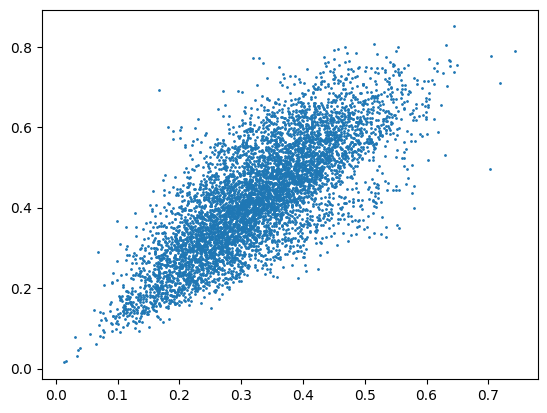

In [79]:
fig, ax = plt.subplots()
plt.scatter(allTestNucProp_true,allTestNucProp_pred,s=1)
# ax.axline((0, 0), slope=1,c='red')

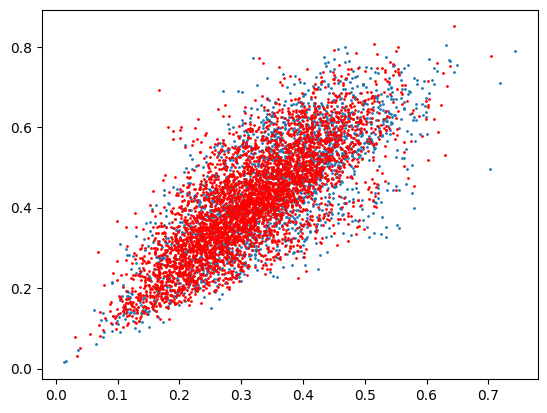

In [129]:
fig, ax = plt.subplots()
plt.scatter(allTestNucProp_true[trainCLIdx],allTestNucProp_pred[trainCLIdx],s=1)
plt.scatter(allTestNucProp_true[testCLIdx],allTestNucProp_pred[testCLIdx],s=1,c='red')
# ax.axline((0, 0), slope=1,c='red')

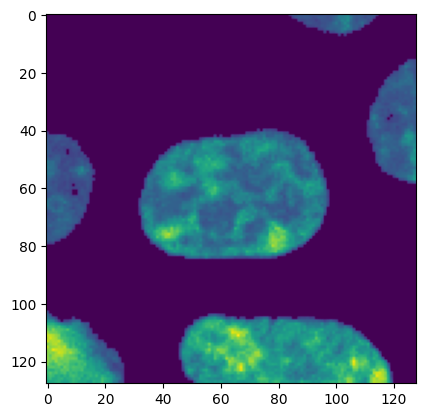

In [109]:
plt.imshow(imgsAll['N4BP2']['HEK'][1,0])

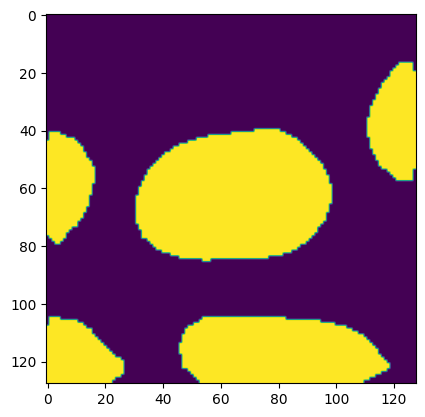

In [110]:
labeled_nuclei, linfo = model_stardist.predict_instances(gaussian(normalize(imgsAll['N4BP2']['HEK'][1,0])))
nuc_mask=np.zeros((128,128))
nuc_mask[labeled_nuclei>0]=1
plt.imshow(nuc_mask)

In [57]:
from scipy import stats

In [58]:
corr,pval=stats.pearsonr(allTestNucProp_true,allTestNucProp_pred)
print(corr)
print(pval)

0.7674263041733572
0.0


In [123]:
nCorrect=np.sum((allTestNucProp_pred_mE*allTestNucProp_true_mE)>0)
print(nCorrect/allTestNucProp_pred_mE.size)


0.8324540367705835


In [81]:
for pname in np.unique(allTestPnames):
    print(pname)
    corr,pval=stats.pearsonr(allTestNucProp_true[allTestPnames==pname],allTestNucProp_pred[allTestPnames==pname])
    print(corr)
    print(pval)

ATP13A5
0.9199600420755601
1.5245078522861739e-231
CHID1
0.4041369639103258
1.3044624008150352e-28
COPA
0.8504280369044566
8.734734720247459e-201
DDIT3
0.867358818651038
7.425273375081104e-236
EIF4G1
0.8282851107088148
9.501431264531665e-176
MESD
0.7632193595975219
2.995769134403652e-147
N4BP2
0.8434282884191407
1.1125838470329513e-182
PSME3IP1
0.6494676701016262
3.451267703795951e-83
RBM23
0.8099321010380428
9.874434728256697e-163


In [97]:
for clname in np.unique(allTestCL):
    print(clname)
    corr,pval=stats.pearsonr(allTestNucProp_true[allTestCL==clname],allTestNucProp_pred[allTestCL==clname])
    print(corr)
    print(pval)

A375
0.791584641797013
0.0
GAMG
0.7555728126536903
5.997797582202221e-119
HEK
0.7539075638463343
1.101544001115087e-253
Hela
0.7960484363531681
5.763810789620827e-202
MCF7
0.7174230479773368
1.1369598567983798e-200


In [132]:
#top pair ranked by std-error
p_cl_pair=np.copy(allTestPnames)
for p in range(p_cl_pair.size):
    p_cl_pair[p]=p_cl_pair[p]+'_'+allTestCL[p]

In [133]:
pclnames,pcounts=np.unique(p_cl_pair,return_counts=True)
pclnames=pclnames[pcounts>10]
pclvar_pred=np.zeros(pclnames.size)
pclmean_pred=np.zeros(pclnames.size)
pclvar_true=np.zeros(pclnames.size)
pclmean_true=np.zeros(pclnames.size)
pclerror=np.zeros(pclnames.size)
allError_nuc=allTestNucProp_pred-allTestNucProp_true
for p in range(pclnames.size):
    pclvar_pred[p]=np.var(allTestNucProp_pred[p_cl_pair==pclnames[p]])
    pclvar_true[p]=np.var(allTestNucProp_true[p_cl_pair==pclnames[p]])
    
    pclmean_pred[p]=np.mean(allTestNucProp_pred[p_cl_pair==pclnames[p]])
    pclmean_true[p]=np.mean(allTestNucProp_true[p_cl_pair==pclnames[p]])
    
    pclerror[p]=np.mean(np.abs(allError_nuc[p_cl_pair==pclnames[p]]))

In [134]:
top_var_idx=np.argsort(-pclvar_pred)
top_var_idx_true=np.argsort(-pclvar_true)
top_var_idx_errorSub=np.argsort(-(np.sqrt(pclvar_pred)-pclerror))
nplot=top_var_idx.size
topPairs_pred=pclnames[top_var_idx[:nplot]]
topPairs_true=pclnames[top_var_idx_true[:nplot]]
topPairs_pred_errorSub=pclnames[top_var_idx_errorSub[:nplot]]

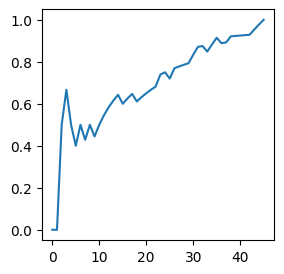

In [146]:
consensusCount=np.zeros(nplot+1)
for nplot_i in range(1,nplot+1):
    topPairs_pred=pclnames[top_var_idx[:nplot_i]]
    topPairs_true=pclnames[top_var_idx_true[:nplot_i]]
    consensusCount[nplot_i]=np.intersect1d(topPairs_pred,topPairs_true).size/nplot_i
    
fig, ax = plt.subplots(figsize=(3,3))

plt.plot(np.arange(nplot+1),consensusCount)

In [285]:
#protein ranking by variance
highThresh=2/3
lowThresh=1/3
pnames=np.unique(allTestPnames)
clnames=np.unique(allTestCL)
nucProp_p_cl_thresh=np.zeros((pnames.size,clnames.size))

for clidx in range(clnames.size):
    cl=clnames[clidx]
    print(cl)

    for pidx in range(pnames.size):
        p=pnames[pidx]
        print(p)
        
        nucPropCurrIdx=np.logical_and(allTestPnames==p,allTestCL==cl)
        nucPropRaw=allTestNucProp_pred[nucPropCurrIdx]
        nucPropCurr=np.zeros(nucPropRaw.size)
        nucPropCurr[nucPropRaw>highThresh]=1
        nucPropCurr[nucPropRaw<lowThresh]=-1
        
        nucProp_p_cl_thresh[pidx,clidx]=np.mean(nucPropCurr)

A375
ATP13A5
CHID1
COPA
DDIT3
EIF4G1
MESD
N4BP2
PSME3IP1
RBM23
GAMG
ATP13A5
CHID1
COPA
DDIT3
EIF4G1
MESD
N4BP2
PSME3IP1
RBM23
HEK
ATP13A5
CHID1
COPA
DDIT3
EIF4G1
MESD
N4BP2
PSME3IP1
RBM23
Hela
ATP13A5
CHID1
COPA
DDIT3
EIF4G1
MESD
N4BP2
PSME3IP1
RBM23
MCF7
ATP13A5
CHID1
COPA
DDIT3
EIF4G1
MESD
N4BP2
PSME3IP1
RBM23


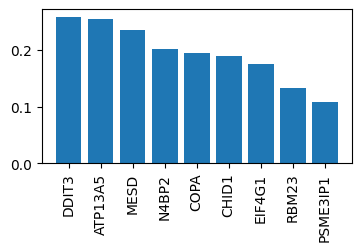

In [286]:
nucProp_p_cl_thresh_var=np.std(nucProp_p_cl_thresh,axis=1)
rankThreshVarPidx=np.argsort(-nucProp_p_cl_thresh_var)
plt.figure(figsize=(4,2))
plt.bar(np.arange(pnames.size),nucProp_p_cl_thresh_var[rankThreshVarPidx])
plt.xticks(np.arange(pnames.size), pnames[rankThreshVarPidx], rotation='vertical')
# plt.axhline(np.median(nucProp_p_cl_thresh_var),color='r')
# plt.axhline(np.min(nucProp_p_cl_thresh_var),color='black')
plt.show()

In [289]:
#protein ranking by variance
highThresh=2/3
lowThresh=1/3
pnames=np.unique(allTestPnames)
clnames=np.unique(allTestCL)
nucProp_p_cl_thresh_true=np.zeros((pnames.size,clnames.size))

for clidx in range(clnames.size):
    cl=clnames[clidx]
    print(cl)

    for pidx in range(pnames.size):
        p=pnames[pidx]
        print(p)
        
        nucPropCurrIdx=np.logical_and(allTestPnames==p,allTestCL==cl)
        nucPropRaw=allTestNucProp_true[nucPropCurrIdx]
        nucPropCurr=np.zeros(nucPropRaw.size)
        nucPropCurr[nucPropRaw>highThresh]=1
        nucPropCurr[nucPropRaw<lowThresh]=-1
        
        nucProp_p_cl_thresh_true[pidx,clidx]=np.mean(nucPropCurr)

A375
ATP13A5
CHID1
COPA
DDIT3
EIF4G1
MESD
N4BP2
PSME3IP1
RBM23
GAMG
ATP13A5
CHID1
COPA
DDIT3
EIF4G1
MESD
N4BP2
PSME3IP1
RBM23
HEK
ATP13A5
CHID1
COPA
DDIT3
EIF4G1
MESD
N4BP2
PSME3IP1
RBM23
Hela
ATP13A5
CHID1
COPA
DDIT3
EIF4G1
MESD
N4BP2
PSME3IP1
RBM23
MCF7
ATP13A5
CHID1
COPA
DDIT3
EIF4G1
MESD
N4BP2
PSME3IP1
RBM23


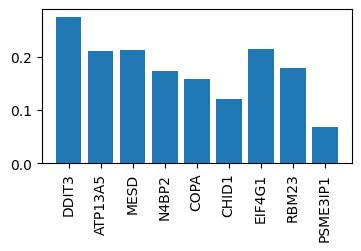

In [290]:
nucProp_p_cl_thresh_var_true=np.std(nucProp_p_cl_thresh_true,axis=1)
rankThreshVarPidx=np.argsort(-nucProp_p_cl_thresh_var)
plt.figure(figsize=(4,2))
plt.bar(np.arange(pnames.size),nucProp_p_cl_thresh_var_true[rankThreshVarPidx])
plt.xticks(np.arange(pnames.size), pnames[rankThreshVarPidx], rotation='vertical')
# plt.axhline(np.median(nucProp_p_cl_thresh_var),color='r')
# plt.axhline(np.min(nucProp_p_cl_thresh_var),color='black')
plt.show()